# Maximum A Posteriori estimation (MAP)
Pierre-Nicolas Suau

Subject: https://fr.wikipedia.org/wiki/Maximum_a_posteriori 

References: https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-and-maximum-a-posteriori-estimation-d7c318f9d22d <br>
https://scikit-learn.org/stable/modules/naive_bayes.html <br>
http://www.bdhammel.com/mle-map/ <br>


In [1]:
import numpy as np
from scipy.stats import norm, invgamma,beta,binom,chi2
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### First of all, let's get back to Maximum Likelihood Estimation (MLE).

Suppose that we have a statistical model and observations of a problem. Let's note $\theta$ the parameter of that model and $y$ the observations. Estimating the parameter using MLE is choosing $\theta$ in the parameter space that maximizes the likelihood function : $\mathbb{P}(Y=y|\Theta=\theta)$.

### Now, let's have a look to Maximum A Posteriori estimation (MAP).
As previously, suppose that we have a statistical model and observations of a problem. Let's note 𝜃 the parameter of that model, 𝑦 the observations and also a distribution that quantifies ouf belief of the parameter value before taking into account any observations $\mathbb{P}(\Theta=\theta)$ (it's called the prior).
Estimating the parameter using MAP is choosing the parameter $\theta$ that maximizes $\mathbb{P}(\Theta=\theta|Y=y)$.

If we use the Bayes theorem we can write:
$$\mathbb{P}(\Theta=\theta|Y=y) =\frac{\mathbb{P}(Y=y|\Theta=\theta)\cdot\mathbb{P}(\Theta=\theta)}{\mathbb{P}(Y=y)}$$
Given that the denominator does not depend on $\theta$, we can only maximizes the numerator which is the likelihood multiplied by the prior.

NB : Note that if we consider that we do not have any prior infomation ie $\mathbb{P}(\Theta=\theta)$ is the uniform distribution, then maximizing the posterior function is equivalent to maximizing the likelihood function.

### Let's take an example

<img src="kylian.jpeg" alt="drawing" width="400"/>


We will consider the probability that Kylian Mbappé scores during the next match according his current form (number of matches with a least one goal over $N=5$ last matches). Suppose that the number of matches with a goal follows a binomial distribution with a probability $\theta$.

Lets note that Kylian scores during $k$ matches out of $n$ matches.
If we assume that the probability of the number of matches during Kylian scores follows a binomial distribution,  it's given by :
$$P(k\ matches\ with\ a\ goal\ over\ n|\Theta=\theta) =\binom{n}{k} \theta^{k} (1-\theta)^{n-k}$$

Our goal (lol) is to estimate theta. Our observed data is here the number of matches with a Kylian goal: $G=1$. 

#### With MLE
Here the likelihood function is :
$\mathbb{P}(k=G,n=N|\Theta=\theta)$.

The value of θ maximising the likelihood can be obtained by having derivative of the likelihood function with respect to θ, and setting it to zero :
$\frac{dP}{d\theta}(k=G,n=N|\Theta=\theta)=0$

The solutions are $0$, $1$ or $\frac{G}{N}$, because the likelihood function is defined over $[0,1]$, positive and  not the zero function, the maximum is reached for $\theta = \frac{G}{N}=0.2$.

#### With MAP
We all know that Kylian Mbappé is a really good striker, so only having $0.2$ does not look satisfying. Traducing "being a good striker" into mathematical terms is assuming that $\theta$ is more likely to be close to 1 than to 0. 
For example we will take the beta distribution with $\alpha=5$ and $\beta=1$ as prior : $\mathbb{P}(\Theta=\theta)=\frac{\Gamma (\alpha + \beta)}{\Gamma (\alpha)\Gamma (\beta)}\theta^{\alpha - 1} (1-\theta)^{\beta -1}$.

Intuitively, MAP needs more information than MLE (here Mbappé is good striker) but performs better with few data (only last five matches).

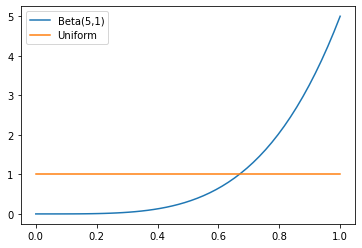

In [2]:
#Run this cell to visualize the beta distribution.
[a, b] = [5, 1]
beta_51 = beta(a, b)
distribution = np.linspace(0, 1) 
plt.plot(distribution, beta_51.pdf(distribution),label='Beta(5,1)') 
plt.plot(distribution, np.ones(distribution.shape),label='Uniform') 
plt.legend()
plt.show()

We have to maximize : $\mathbb{P}(k=G,n=N|\Theta=\theta)\cdot\mathbb{P}(\Theta=\theta) =\binom{n}{k} \frac{\Gamma (\alpha + \beta)}{\Gamma (\alpha)\Gamma (\beta)}\theta^{\alpha - 1} \theta^{k + \alpha -1} (1-\theta)^{n-k + \beta -1}$

So let's compute the Kylian MAP (lol), the result is $\frac{k + \alpha -1}{n+\alpha+\beta-2}=\frac{5}{9}=0.55$

We found maximas of our functions analytically but we can do it computionally with a grid approximation. It means that we make guesses for theta (for example : [0, 0.001, 0.002 ... 1]), then compute our function (likelihood or likelihood multiplied by prior) and finally we take theta which maximizes that function as solution. It allows us to use any fonction as prior.

NB : We will compute the log of the functions, so the multiplication between the likelihood and the prior become an addition.

In [3]:
def get_mle(guesses,log_likelihood):
    """
    This function returns the MLE over guesses.
    """
    idx = np.argwhere(log_likelihood == log_likelihood.max())
    return guesses[idx][0,0]


def get_map(guesses,log_likelihood,log_prior):
    """
    This function returns the MAP over guesses.
    """
    log_posterior = log_likelihood + log_prior
    idx = np.argwhere(log_posterior == log_posterior.max())
    return guesses[idx][0,0]

In [4]:
#Observations
G=1 # One match with a goal
N=5 # Over five matches

theta_guesses = np.linspace(0.001, 1, 1000)

#First we compute the log_likelihood over the guesses
log_likelihood = np.asarray([binom.logpmf(G, N, theta) for theta in theta_guesses]) 

#Then we compute the MLE
mle=get_mle(theta_guesses,log_likelihood)
print("MLE",mle)

#Now we compute the log prior
log_prior_beta_51 = [beta_51.logpdf(theta) for theta in theta_guesses]

#Finally we compute the MAP with beta(5,1) prior
map_beta_51=get_map(theta_guesses,log_likelihood,log_prior_beta_51)
print("MAP with beta(5,1) prior",map_beta_51)

MLE 0.2
MAP with beta(5,1) prior 0.556


As expected, we found the same result.

We can verify if MAP with a uniform prior returns the same result as MAP.

In [5]:
log_prior_uniform = [np.log(1) for theta in theta_guesses]

map_uniform=get_map(theta_guesses,log_likelihood,log_prior_uniform)
print("MAP with uniform prior",map_uniform)

MAP with uniform prior 0.2


Now let's have a look to the prior influence by comparing results with several functions.

In [6]:
def step_function(array):
    return 2*(np.ones(array.shape)-array <0.5)

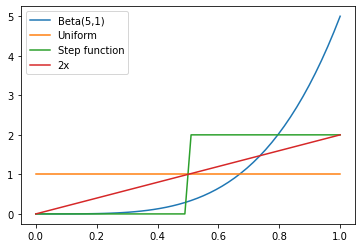

In [7]:
distribution = np.linspace(0, 1) 
plt.plot(distribution, beta_51.pdf(distribution),label="Beta(5,1)")
plt.plot(distribution, np.ones(distribution.shape),label="Uniform")
plt.plot(distribution,step_function(distribution),label="Step function")
plt.plot(distribution, 2*(distribution**1),label="2x")  
plt.legend()
plt.show()

In [8]:
log_prior_step = np.log(step_function(theta_guesses))
map_beta_step=get_map(theta_guesses,log_likelihood,log_prior_step)
print("MAP with step prior",map_beta_step)

log_prior_2x = [np.log(2*theta) for theta in theta_guesses]
map_beta_2x=get_map(theta_guesses,log_likelihood,log_prior_2x)
print("MAP with 2x prior",map_beta_2x)

#Previous results
print("MAP with beta(5,1) prior",map_beta_51)

MAP with step prior 0.501
MAP with 2x prior 0.333
MAP with beta(5,1) prior 0.556


As we could have expected it intuitively, the more our prior function is high close to 1 and low close 0 the higher the MAP is. We can also notice that our step function just forbides to have theta $<0.5$.

Feel free to re-run the code with other values of $(G,N)$.
You can also test your own prior function with the following cell.

In [ ]:
def prior_function(array):
    """
    Takes an array of theta guesses as input and returns the corresponding prior values (np.array).
    """
    ### To complete
    prior="..."
    return prior

plt.plot(distribution,prior_function(distribution),label="Prior function")  
plt.legend()
plt.show()

log_prior_custom = np.log(prior_function(theta_guesses))
map_beta_custom=get_map(theta_guesses,log_likelihood,log_prior_custom)
print("MAP with custom prior",map_beta_custom)

### Let's take another example for non football fans

<img src="jambon.jpeg" alt="drawing" width="400"/>

A strong tradition in France during "fete du village" is to estimate the weight of an entire raw ham, the one with the closest estimation wins the ham. The only data available is all the estimations made by other candidates (you can also take the ham in you hands but it won't be useful for our model here). We will generate estimations from other candidates with a gaussian around the real weight.

So, we'll try to estimate the weight of the ham only using others' estimations. To do that, we need to make two guesses : the real weight and the error made by others (the standard deviation). Then we do the same thing as in the previous example with MLE and MAP (note that there are two prior functions, one for each guess).


In [9]:
def get_log_likelihood_grid(estimations,WEIGHT_GUESSES,ERROR_GUESSES):
    log_liklelihood = [
        [
            norm(weight_guess, error_guess).logpdf(estimations).sum()
            for weight_guess in WEIGHT_GUESSES
        ]
        for error_guess in ERROR_GUESSES
    ]
    return np.asarray(log_liklelihood)


def get_mle(estimations,WEIGHT_GUESSES,ERROR_GUESSES):
    log_likelihood = get_log_likelihood_grid(estimations,WEIGHT_GUESSES,ERROR_GUESSES)
    idx = np.argwhere(log_likelihood == log_likelihood.max())[0][1]
    return WEIGHT_GUESSES[idx]


def get_map(estimations,WEIGHT_GUESSES,ERROR_GUESSES,LOG_PRIOR_GRID):
    log_likelihood = get_log_likelihood_grid(estimations,WEIGHT_GUESSES,ERROR_GUESSES)
    log_posterior = log_likelihood + LOG_PRIOR_GRID
    idx = np.argwhere(log_posterior == log_posterior.max())[0][1]
    return WEIGHT_GUESSES[idx]

In [10]:
# Real weight 
weight=3.46 # you can try with another weight

#Estimations from other candidates (in reality we wont know that)
scale_error_estimation=0.3
nb_canditates=10
weight_estimations = weight + np.random.normal(loc=0, scale=scale_error_estimation,size=nb_canditates) # observations

# Guesses
weight_guesses = np.linspace(3, 4, 101)
error_guesses = np.linspace(.1, 0.5, 100)

# NOTE: Try changing the prior values and distributions
PRIOR_WEIGHT = norm(3.500, 0.2).logpdf(weight_guesses)
PRIOR_ERR = invgamma(5).logpdf(error_guesses)
prior_grid = np.add.outer(PRIOR_ERR, PRIOR_WEIGHT)

print(f"The true weight of the jambon was: {weight:.3f} kg")
print(f"Average measurement: {weight_estimations.mean():.3f} kg")
print(f"Maximum Likelihood estimate: {get_mle(weight_estimations,weight_guesses,error_guesses):.3f} kg")
print(f"Maximum A Posteriori estimate: {get_map(weight_estimations,weight_guesses,error_guesses,prior_grid):.3f} kg")

The true weight of the jambon was: 3.460 kg
Average measurement: 3.225 kg
Maximum Likelihood estimate: 3.230 kg
Maximum A Posteriori estimate: 3.280 kg


### MAP and machine learning 

Naive Bayes methods are a set of machine learning algorithms widely used in classification for example. The probability to belong to a class is estimated with MLE or MAP (cf https://scikit-learn.org/stable/modules/naive_bayes.html).

Thank you for running my notebook, I tried to put some jokes in a serious work to relax ourselves in such a stressful period.

PS: Feel free to follow me on github, username : pnsuau (https://github.com/pnsuau).